In [1]:
pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, length, split, explode,avg, lower
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("MedicineRecommendation") \
    .getOrCreate()


In [4]:
# Load CSV files into DataFrames
company_df = spark.read.csv('Company_Name.csv', header=True, inferSchema=True)
medicine_df = spark.read.csv('Medicine_description.csv', header=True, inferSchema=True)
rating_df = spark.read.csv('Ratings.csv', header=True, inferSchema=True)

In [5]:
company_df.show()

+----+--------------------+----------+------+--------------------+
|S.No|        Company_Name|NSE_Symbol|Rating|            Industry|
+----+--------------------+----------+------+--------------------+
|   1|Sun Pharmaceutica...| SUNPHARMA|     S|Pharmaceuticals &...|
|   2|Dr. Reddys Labora...|   DRREDDY|     R|Pharmaceuticals &...|
|   3|Divis Laboratorie...|  DIVISLAB|     D|Pharmaceuticals &...|
|   4|          Cipla Ltd.|     CIPLA|     C|Pharmaceuticals &...|
|   5|         Biocon Ltd.|    BIOCON|     B|Pharmaceuticals &...|
|   6|Aurobindo Pharma ...|AUROPHARMA|    AU|Pharmaceuticals &...|
|   7|Torrent Pharmaceu...|TORNTPHARM|     T|Pharmaceuticals &...|
|   8|          Lupin Ltd.|     LUPIN|     L|Pharmaceuticals &...|
|   9|Cadila Healthcare...|  CADILAHC|    CA|Pharmaceuticals &...|
|  10|   Abbott India Ltd.|ABBOTINDIA|   ABB|Pharmaceuticals &...|
|  11|Alkem Laboratorie...|     ALKEM|    AL|Pharmaceuticals &...|
|  12|Glaxosmithkline P...|     GLAXO|     G|Pharmaceuticals &

In [6]:
rating_df.show()

+----------+------+
|Short-form|Rating|
+----------+------+
|         S|   4.8|
|         R|   4.7|
|         D|   4.5|
|         C|   4.3|
|         B|   4.1|
|        AU|   3.9|
|         T|   3.5|
|         L|   3.4|
|        CA|   3.3|
|       ABB|  3.25|
|        AL|   3.2|
|         G|   3.1|
|         I|   3.0|
|      ALEM|   2.9|
|        GL|   2.7|
|        JB|   2.5|
+----------+------+



In [7]:
medicine_df.show()

+--------------------+------+--------------------+
|           Drug_Name|Reason|         Description|
+--------------------+------+--------------------+
|A CN Gel(Topical)...|  Acne|Mild to moderate ...|
|A Ret 0.05% Gel 2...|  Acne|A RET 0.025% is a...|
|ACGEL CL NANO Gel...|  Acne|It is used to tre...|
| ACGEL NANO Gel 15gm|  Acne|It is used to tre...|
|Acleen 1% Lotion ...|  Acne|treat the most se...|
|Aclene 0.10% Gel ...|  Acne|treat the most se...|
|      Acnay Gel 10gm|  Acne|treat the most se...|
|Acne Aid Bar 50gm...|  Acne|�treat acne vulga...|
|    Acne UV Gel 60gm|  Acne|�treat acne vulga...|
|Acne UV SPF 30 Ge...|  Acne|�treat mild to mo...|
|   Acnecure Gel 20gm|  Acne|treatment of dry ...|
|    Acnedap Gel 15gm|  Acne|Mild to moderate ...|
|Acnedap Plus Gel ...|  Acne|A RET 0.025% is a...|
|    Acnehit Gel 15gm|  Acne|It is used to tre...|
|   Acnelak Soap 75gm|  Acne|It is used to tre...|
|Acnelak Clz Cream...|  Acne|treat the most se...|
|Acnelak Z Lotion ...|  Acne|tr

CHECKING THE DATATYPES OF EACH COLUMNS

In [8]:
company_df.dtypes

[('S.No', 'int'),
 ('Company_Name', 'string'),
 ('NSE_Symbol', 'string'),
 ('Rating', 'string'),
 ('Industry', 'string')]

In [9]:
medicine_df.dtypes

[('Drug_Name', 'string'), ('Reason', 'string'), ('Description', 'string')]

In [10]:
rating_df.dtypes

[('Short-form', 'string'), ('Rating', 'double')]

In [11]:
# Standardising column name
from pyspark.sql.functions import col, sum
company_df=company_df.withColumnRenamed("S.No","S_No")

#check for missing values in each column
def check_missing_values(df):
    return df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

check_missing_values(company_df)
check_missing_values(medicine_df)
check_missing_values(rating_df)

+----+------------+----------+------+--------+
|S_No|Company_Name|NSE_Symbol|Rating|Industry|
+----+------------+----------+------+--------+
|   0|           0|         0|     0|       0|
+----+------------+----------+------+--------+

+---------+------+-----------+
|Drug_Name|Reason|Description|
+---------+------+-----------+
|        0|     0|         14|
+---------+------+-----------+

+----------+------+
|Short-form|Rating|
+----------+------+
|         0|     0|
+----------+------+



In [12]:
# drop rows with missing values in a particular column
cleaned_medicine_df=medicine_df.dropna(subset=['Description'])

In [13]:
#check whether missing values are removed or not
check_missing_values(cleaned_medicine_df)

+---------+------+-----------+
|Drug_Name|Reason|Description|
+---------+------+-----------+
|        0|     0|          0|
+---------+------+-----------+



In [14]:
cleaned_medicine_df.show()

+--------------------+------+--------------------+
|           Drug_Name|Reason|         Description|
+--------------------+------+--------------------+
|A CN Gel(Topical)...|  Acne|Mild to moderate ...|
|A Ret 0.05% Gel 2...|  Acne|A RET 0.025% is a...|
|ACGEL CL NANO Gel...|  Acne|It is used to tre...|
| ACGEL NANO Gel 15gm|  Acne|It is used to tre...|
|Acleen 1% Lotion ...|  Acne|treat the most se...|
|Aclene 0.10% Gel ...|  Acne|treat the most se...|
|      Acnay Gel 10gm|  Acne|treat the most se...|
|Acne Aid Bar 50gm...|  Acne|�treat acne vulga...|
|    Acne UV Gel 60gm|  Acne|�treat acne vulga...|
|Acne UV SPF 30 Ge...|  Acne|�treat mild to mo...|
|   Acnecure Gel 20gm|  Acne|treatment of dry ...|
|    Acnedap Gel 15gm|  Acne|Mild to moderate ...|
|Acnedap Plus Gel ...|  Acne|A RET 0.025% is a...|
|    Acnehit Gel 15gm|  Acne|It is used to tre...|
|   Acnelak Soap 75gm|  Acne|It is used to tre...|
|Acnelak Clz Cream...|  Acne|treat the most se...|
|Acnelak Z Lotion ...|  Acne|tr

In [15]:

from pyspark.sql.functions import col, trim, regexp_replace

# Apply transformations
cleaned_medicine_df = cleaned_medicine_df.select([
    # Remove leading/trailing white spaces
    trim(col("Drug_Name")).alias("Drug_Name"),
    trim(col("Reason")).alias("Reason"),
    # Replace non-printable characters and multiple spaces
    regexp_replace(trim(col("Description")), '[^\x00-\x7F]+', '').alias("Description")
])
cleaned_medicine_df = cleaned_medicine_df.withColumn(
    "Description",
    trim(col("Description"))
)

In [16]:
cleaned_medicine_df.show()

+--------------------+------+--------------------+
|           Drug_Name|Reason|         Description|
+--------------------+------+--------------------+
|A CN Gel(Topical)...|  Acne|Mild to moderate ...|
|A Ret 0.05% Gel 2...|  Acne|A RET 0.025% is a...|
|ACGEL CL NANO Gel...|  Acne|It is used to tre...|
| ACGEL NANO Gel 15gm|  Acne|It is used to tre...|
|Acleen 1% Lotion ...|  Acne|treat the most se...|
|Aclene 0.10% Gel ...|  Acne|treat the most se...|
|      Acnay Gel 10gm|  Acne|treat the most se...|
|Acne Aid Bar 50gm...|  Acne| treat acne vulgaris|
|    Acne UV Gel 60gm|  Acne| treat acne vulgaris|
|Acne UV SPF 30 Ge...|  Acne|treat mild to mod...|
|   Acnecure Gel 20gm|  Acne|treatment of dry ...|
|    Acnedap Gel 15gm|  Acne|Mild to moderate ...|
|Acnedap Plus Gel ...|  Acne|A RET 0.025% is a...|
|    Acnehit Gel 15gm|  Acne|It is used to tre...|
|   Acnelak Soap 75gm|  Acne|It is used to tre...|
|Acnelak Clz Cream...|  Acne|treat the most se...|
|Acnelak Z Lotion ...|  Acne|tr

In [17]:
#checking duplicates in the datasets
company_duplicates=company_df.groupBy(company_df.columns).count().filter(col("count")>1)
company_duplicates.show()
medicine_duplicates=cleaned_medicine_df.groupBy(cleaned_medicine_df.columns).count().filter(col("count")>1)
medicine_duplicates.show()
rating_duplicates=rating_df.groupBy(rating_df.columns).count().filter(col("count")>1)
rating_duplicates.show()

+----+------------+----------+------+--------+-----+
|S_No|Company_Name|NSE_Symbol|Rating|Industry|count|
+----+------------+----------+------+--------+-----+
+----+------------+----------+------+--------+-----+

+---------+------+-----------+-----+
|Drug_Name|Reason|Description|count|
+---------+------+-----------+-----+
+---------+------+-----------+-----+

+----------+------+-----+
|Short-form|Rating|count|
+----------+------+-----+
+----------+------+-----+



In [18]:
# Rename columns for clarity
company_df = company_df.withColumnRenamed("Rating", "Short-form")

# Join company_df with ratings_df on 'Short-form'
combined_df = company_df.join(rating_df, on='Short-form', how='left')

# Drop the 'Short-form' column if it's no longer needed
combined_df = combined_df.drop('Short-form')

#remove duplicates based on Company_Name
cleaned_combined_df= combined_df.dropDuplicates(['Company_Name'])


In [19]:
cleaned_combined_df.show()

+----+--------------------+----------+--------------------+------+
|S_No|        Company_Name|NSE_Symbol|            Industry|Rating|
+----+--------------------+----------+--------------------+------+
|  10|   Abbott India Ltd.|ABBOTINDIA|Pharmaceuticals &...|  3.25|
|  14|Alembic Pharmaceu...|   ALEMBIC|Pharmaceuticals &...|   2.9|
|  11|Alkem Laboratorie...|     ALKEM|Pharmaceuticals &...|   3.2|
|   6|Aurobindo Pharma ...|AUROPHARMA|Pharmaceuticals &...|   3.9|
|   5|         Biocon Ltd.|    BIOCON|Pharmaceuticals &...|   4.1|
|   9|Cadila Healthcare...|  CADILAHC|Pharmaceuticals &...|   3.3|
|   4|          Cipla Ltd.|     CIPLA|Pharmaceuticals &...|   4.3|
|   3|Divis Laboratorie...|  DIVISLAB|Pharmaceuticals &...|   4.5|
|   2|Dr. Reddys Labora...|   DRREDDY|Pharmaceuticals &...|   4.7|
|  12|Glaxosmithkline P...|     GLAXO|Pharmaceuticals &...|   3.1|
|  15|Glenmark Pharmace...|  GLENMARK|Pharmaceuticals &...|   2.7|
|  13|Ipca Laboratories...|   IPCALAB|Pharmaceuticals &...|   

In [20]:
# Convert Spark DataFrame to Pandas DataFrame
cleaned_combined_pd=cleaned_combined_df.toPandas()
cleaned_medicine_pd=cleaned_medicine_df.toPandas()

# Save Pandas DataFrames to CSV files
cleaned_combined_pd.to_csv('C:/Users/sneha/Downloads/Medicine/cleaned_combined.csv', index=False)
cleaned_medicine_pd.to_csv('C:/Users/sneha/Downloads/Medicine/cleaned_medicine.csv', index=False)


In [21]:
# Get top 10 -rated companies 
top_10_rated_companies = cleaned_combined_df.orderBy(cleaned_combined_df['Rating'].desc()).limit(10)

# Show top-rated companies
top_10_rated_companies.show()


+----+--------------------+----------+--------------------+------+
|S_No|        Company_Name|NSE_Symbol|            Industry|Rating|
+----+--------------------+----------+--------------------+------+
|   1|Sun Pharmaceutica...| SUNPHARMA|Pharmaceuticals &...|   4.8|
|   2|Dr. Reddys Labora...|   DRREDDY|Pharmaceuticals &...|   4.7|
|   3|Divis Laboratorie...|  DIVISLAB|Pharmaceuticals &...|   4.5|
|   4|          Cipla Ltd.|     CIPLA|Pharmaceuticals &...|   4.3|
|   5|         Biocon Ltd.|    BIOCON|Pharmaceuticals &...|   4.1|
|   6|Aurobindo Pharma ...|AUROPHARMA|Pharmaceuticals &...|   3.9|
|   7|Torrent Pharmaceu...|TORNTPHARM|Pharmaceuticals &...|   3.5|
|   8|          Lupin Ltd.|     LUPIN|Pharmaceuticals &...|   3.4|
|   9|Cadila Healthcare...|  CADILAHC|Pharmaceuticals &...|   3.3|
|  10|   Abbott India Ltd.|ABBOTINDIA|Pharmaceuticals &...|  3.25|
+----+--------------------+----------+--------------------+------+



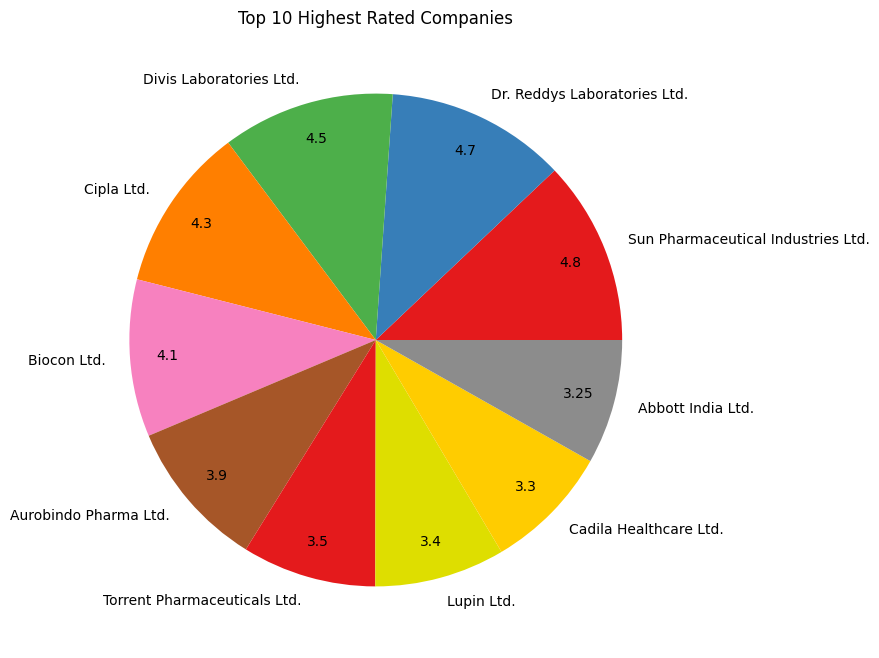

In [22]:
top_10_rated_companies_pd=top_10_rated_companies.toPandas()
plt.figure(figsize=(10, 8))

# Define a custom list of colors
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00', '#f781bf',
          '#a65628', '#e41a1c', '#dede00', '#ffcc00', '#8c8c8c']

# Pie chart
wedges, texts, autotexts = plt.pie(
    top_10_rated_companies_pd['Rating'], 
    labels=top_10_rated_companies_pd['Company_Name'],
    colors=colors,
    autopct='%1.1f%%',  # This displays the percentage on each slice
    pctdistance=0.85    # Adjust this to move the percentage text inside the pie chart
)

# Update autotexts to include the rating information
for autotext, rating in zip(autotexts, top_10_rated_companies_pd['Rating']):
    autotext.set_text(f'{rating}')  # Set the rating instead of percentage

# Add a title
plt.title('Top 10 Highest Rated Companies')

# Save the plot to a file
plt.savefig('top_10_highest_rated_companies_pie.png')
plt.show()


In [23]:
# Number of drugs for a particular reason
num_of_drugs=cleaned_medicine_df.groupBy('Reason').count().withColumnRenamed('count','num_of_drug').orderBy(desc('num_of_drug'))
# Show Number of drugs for a particular reason
num_of_drugs.show()


+-------------+-----------+
|       Reason|num_of_drug|
+-------------+-----------+
|   Supplement|       3913|
|         Pain|       2852|
|    Infection|       2629|
| Hypertension|       2505|
|     Diabetes|       2013|
|       Fungal|        878|
|    Allergies|        851|
|   Depression|        628|
|      Anxiety|        502|
|      Anaemia|        490|
|         Acne|        394|
|       Angina|        327|
|    Psychosis|        301|
| Constipation|        289|
|        Viral|        287|
|    Diarrhoea|        263|
|      General|        243|
|     Malarial|        228|
|Schizophrenia|        217|
|     Glaucoma|        197|
+-------------+-----------+
only showing top 20 rows



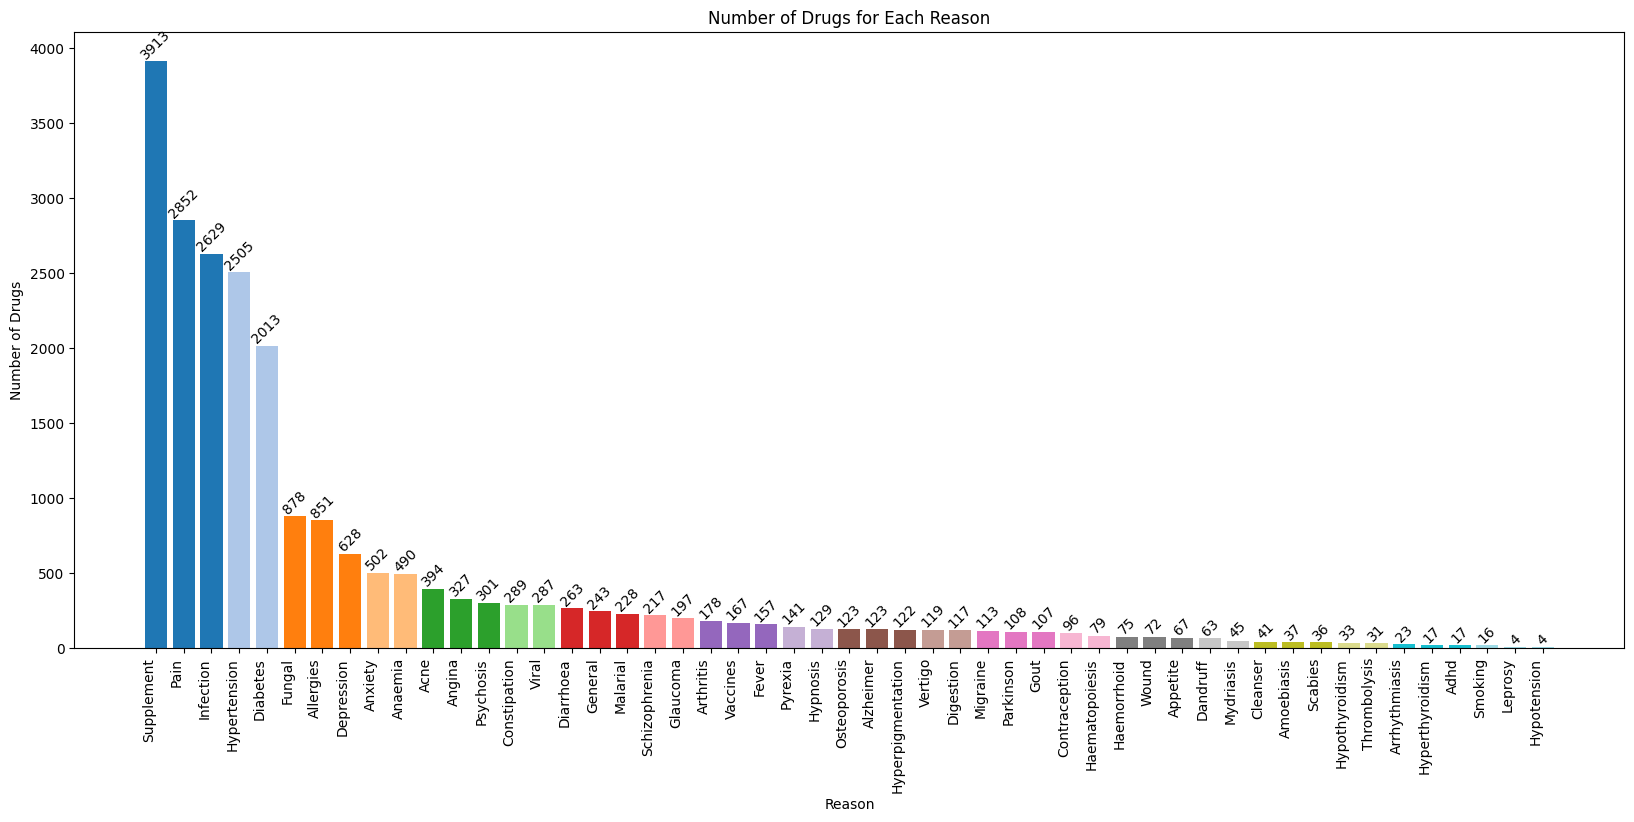

In [24]:
# Convert to Pandas DataFrame for visualization
num_of_drugs_pd = num_of_drugs.toPandas()

# Plot the data
plt.figure(figsize=(20, 8))

# Create a colormap
cmap = plt.get_cmap('tab20', len(num_of_drugs_pd))

# Generate a list of colors
colors = [cmap(i / len(num_of_drugs_pd)) for i in range(len(num_of_drugs_pd))]

# Plot with multicolor bars
bars=plt.bar(num_of_drugs_pd['Reason'], num_of_drugs_pd['num_of_drug'], color=colors)

plt.xlabel('Reason')
plt.ylabel('Number of Drugs')
plt.title('Number of Drugs for Each Reason')
plt.xticks(rotation=90, ha='right')  
# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', rotation=45, color='black')
# Save the plot to a file
plt.savefig('number_of_drugs_for_each_reason.png')

# Show the plot
plt.show()

In [25]:

# Most Frequent Words in Descriptions
words_df = cleaned_medicine_df.withColumn('word', explode(split('Description', ' ')))
word_count = words_df.groupBy('word').count().orderBy('count', ascending=False).limit(20)
word_count.show()


+---------+-----+
|     word|count|
+---------+-----+
|      and|10209|
|       of| 8117|
|      the| 6713|
|       to| 5831|
|       in| 5371|
|    blood| 3946|
|    treat| 3936|
|     used| 3670|
|     with| 2663|
| pressure| 2564|
|     high| 2413|
| diabetes| 2254|
|      for| 2086|
|  reduces| 2039|
|       or| 1942|
|   adults| 1724|
|        a| 1665|
|     your| 1603|
|    which| 1481|
|infection| 1437|
+---------+-----+



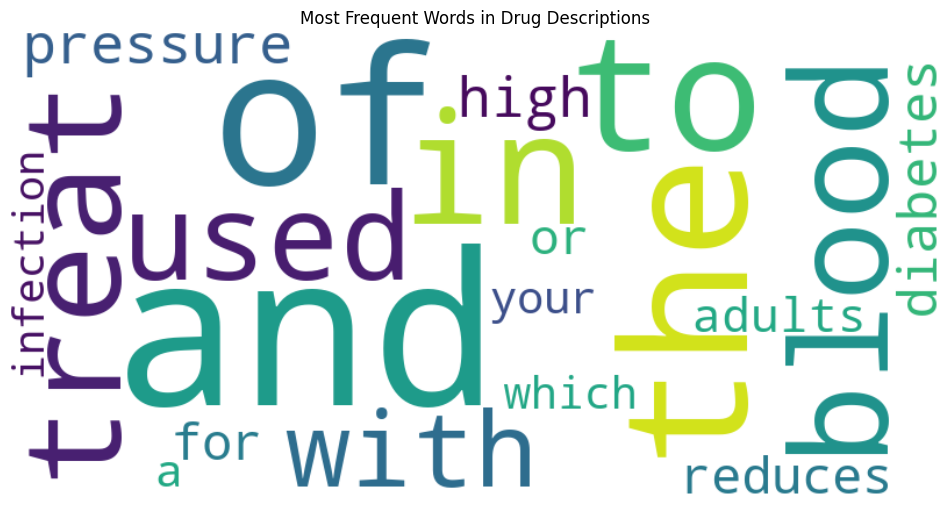

In [26]:
# generate wordcloud
word_count_pd = word_count.toPandas()
# Prepare the word frequency dictionary
word_freq = dict(zip(word_count_pd['word'], word_count_pd['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Do not show axes
plt.title('Most Frequent Words in Drug Descriptions')
# Save the plot to a file
plt.savefig('Most Frequent Words in Descriptions.png')
plt.show()

In [27]:
# Top Drugs by Length of Description

# Add a column for description length
cleaned_medicine_df = cleaned_medicine_df.withColumn('Description_Length', length('Description'))

# Get the top drugs by length of description
top_drugs_by_desc_len = cleaned_medicine_df.orderBy('Description_Length', ascending=False).limit(10)

# Show the result
top_drugs_by_desc_len.show()

+--------------------+-------------+--------------------+------------------+
|           Drug_Name|       Reason|         Description|Description_Length|
+--------------------+-------------+--------------------+------------------+
| Carpela Tablet 21'S|Contraception|treat skin condit...|               258|
|Duoluton L Tablet...|Contraception|treat skin condit...|               258|
|Crisanta Tablet 21'S|Contraception|treat skin condit...|               258|
|Cytolog 200mcg Ta...|Contraception|treat skin condit...|               258|
|Destrogen 0.03/0....|Contraception|treat skin condit...|               258|
|Dienofem 2mg Tabl...|Contraception|treat skin condit...|               258|
|Dinomac 2mg Table...|Contraception|treat skin condit...|               258|
|Dinotop 2mg Table...|Contraception|treat skin condit...|               258|
|   Doris Tablet 21'S|Contraception|treat skin condit...|               258|
|Drosinex 0.03/3mg...|Contraception|treat skin condit...|               258|

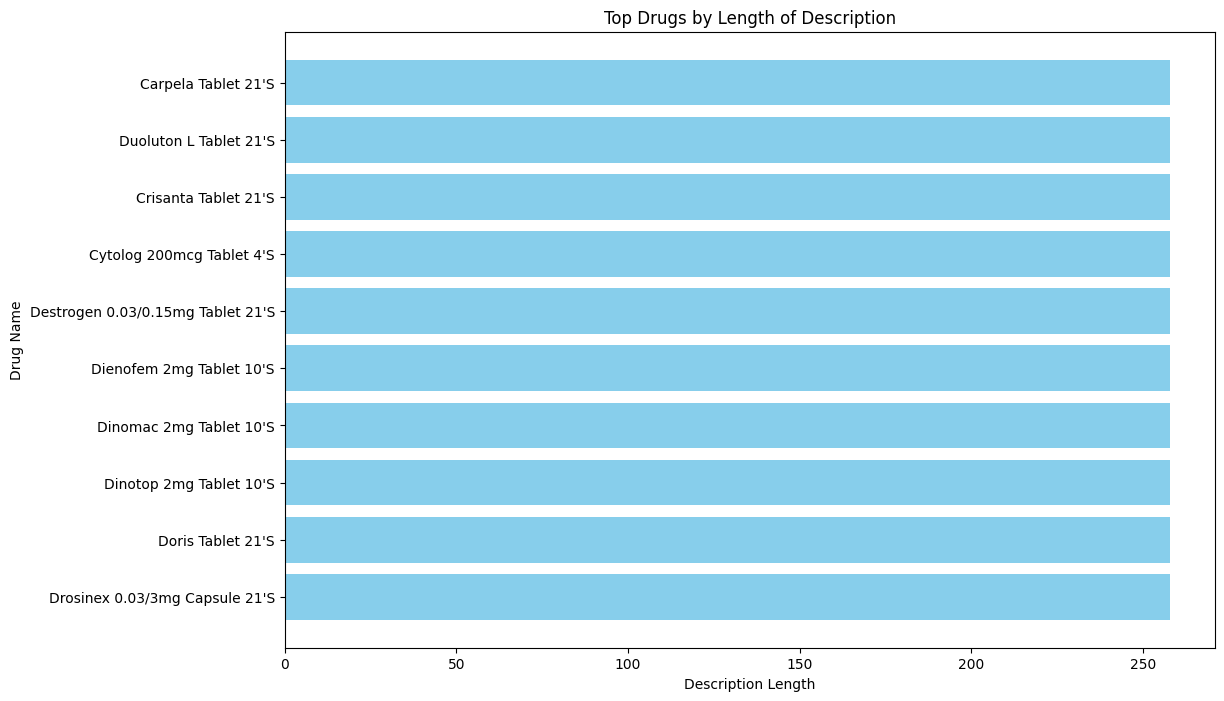

In [28]:
top_drugs_by_desc_len_pd = top_drugs_by_desc_len.toPandas()

plt.figure(figsize=(12, 8))
plt.barh(top_drugs_by_desc_len_pd['Drug_Name'], top_drugs_by_desc_len_pd['Description_Length'], color='skyblue')
plt.xlabel('Description Length')
plt.ylabel('Drug Name')
plt.title('Top Drugs by Length of Description')
plt.gca().invert_yaxis()  # Invert y-axis to have the longest descriptions at the top
# Save the plot to a file
plt.savefig('Top Drugs by Length of Description.png')
plt.show()

In [ ]:
# Function to get valid condition from user
def get_valid_condition(df):
    while True:
        # Get user input for the condition
        condition = input("Enter the condition: ").strip()  # using strip to remove any leading or trailing whitespace
        if not condition:
            print("Error: Condition cannot be empty.")
            continue
        # Convert the user input to lowercase
        lower_condition = condition.lower()
        # Convert the 'Reason' column to lowercase and check for matches
        matching_rows = df.filter(lower(col('Reason')).contains(lower_condition)).count()
        if matching_rows > 0:
            return lower_condition  # Return the lowercase version of the condition
        else:
            print(f"No data found for '{condition}'. Please try again.")

# Main loop to get conditions and show recommendations
while True:
    # Get valid condition from user
    condition = get_valid_condition(cleaned_medicine_df)
    
    
    # Filter the DataFrame for recommended medicines
    recommended_medicines = cleaned_medicine_df.filter(lower(col('Reason')).contains(condition))
    print("\nRecommended Medicines:")
    recommended_medicines.show()

    # Show top 10 rated companies
    print("\nTop 10 Highest Rated Companies:")
    top_10_rated_companies.show()

    # Optionally, ask if user wants to continue or exit
    continue_choice = input("Would you like to search for another condition? (yes to continue, exit to quit): ").strip().lower()
    if continue_choice == 'exit':
        print("Exiting the program.")
        break


Enter the condition:  acne



Recommended Medicines:
+--------------------+------+--------------------+------------------+
|           Drug_Name|Reason|         Description|Description_Length|
+--------------------+------+--------------------+------------------+
|A CN Gel(Topical)...|  Acne|Mild to moderate ...|                29|
|A Ret 0.05% Gel 2...|  Acne|A RET 0.025% is a...|                76|
|ACGEL CL NANO Gel...|  Acne|It is used to tre...|               156|
| ACGEL NANO Gel 15gm|  Acne|It is used to tre...|               156|
|Acleen 1% Lotion ...|  Acne|treat the most se...|                49|
|Aclene 0.10% Gel ...|  Acne|treat the most se...|                49|
|      Acnay Gel 10gm|  Acne|treat the most se...|                49|
|Acne Aid Bar 50gm...|  Acne| treat acne vulgaris|                19|
|    Acne UV Gel 60gm|  Acne| treat acne vulgaris|                19|
|Acne UV SPF 30 Ge...|  Acne|treat mild to mod...|                34|
|   Acnecure Gel 20gm|  Acne|treatment of dry ...|                

Would you like to search for another condition? (yes to continue, exit to quit):  yes
Enter the condition:  Cancer


No data found for 'Cancer'. Please try again.
